# ATCI Practical: Swimmer PPO
autohor: Petr Zelina

I chose to use RL to find a good policy for the MuJoCo [Swimmer](https://www.gymlibrary.ml/environments/mujoco/swimmer/) environment. In it a worm learns to swim in a viscous liquid using its two joints.

At first I tried to solve it with DDQN, but because the action space is continuous, I had to discretize the actions. The algorithm learned only to "jump" (reward ~40) but was not able to learn a continuous slither (reward ~300), as one would expect. Because of this I chose to use the PPO algorithm, as it is able to use continuous actions.

PPO based on implementation by Colin Skow [GitHub](https://github.com/colinskow/move37).

In [18]:
import math
import os
import random
import gym
import numpy as np
from tqdm.auto import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
from torch.utils.tensorboard import SummaryWriter

from IPython.display import clear_output, HTML, Video
import matplotlib.pyplot as plt
%matplotlib inline

## Multi-environment
This class is udsed for interacting with multiple environments at the same time

I tried to use the `desync` function to desynchronise the starting states for the training (use it instead of the initial `reset`), but it lead to worse performance.

In [2]:
class EnvironmentSet:
    def __init__(self, env_id, n):
        self.env_id = env_id
        self.n = n
        self.envs = [gym.make(env_id) for _ in range(n)]
        
    def __enter__(self):
        return self

    def __exit__(self, *args):
        self.close()

    def reset(self):
        states = []
        for env in self.envs:
            states.append(env.reset())
        return np.stack(states)

    def desync(self, step):
        states = []
        for i, env in enumerate(self.envs):
            state = env.reset()
            for s in range(i*step):
                state, reward, done, _ = env.step(env.action_space.sample())
                if done:
                    env.reset()
            states.append(state)
        return np.stack(states)

    def step(self, actions):
        results = []
        for env, a in zip(self.envs, actions):
            state, reward, done, info = env.step(a)
            if done:
                state = env.reset()
            results.append((state, reward, done, info))

        obs, rews, dones, infos = zip(*results)
        return np.stack(obs), np.stack(rews), np.stack(dones), infos

    def close(self):
        for env in self.envs:
            env.close()

## Actor-Critic neural networks
The critic predicts the value of a state, thus it does not have a cropping activation function in the last layer.

The actor predicts the mean of the actions. Because the action space takes values in $[-1, 1]$ I used the Hyperbolic tangens activation function.

The actor should predict the standard deviation as well, but when I put both mean and std to the same network, it was very unstable. Some implementations I found used a static std or a single-trainable parameter (per action) std. I settled on a compromise - a single layer network (linear transformation of the current state).

In [3]:
import torch
import torch.nn as nn
from torch.distributions import Normal

class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size, std=0.0):
        super(ActorCritic, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_outputs),
            nn.Tanh(),
        )
        
        self.log_std = nn.Sequential(
            # nn.Linear(num_inputs, 32),
            # nn.Sigmoid(),
            # nn.Linear(32, num_outputs),
            nn.Linear(num_inputs, num_outputs),
        )
        
    def forward(self, state):
        value = self.critic(state)
        mu    = self.actor(state)
        std   = self.log_std(state).exp()
        dist  = Normal(mu, std)
        return dist, value

## Configuration
I experimented with different configurations.

With the current setting, the PPO learns from 256 \* 8 environment steps each learning step. To update the weights in each learning step, it does 10 (epochs) \* 4 batches of 64 learning examples. 

Each 10 learning steps, the model is evaluated on 10 full episodes. (the test reward)

`GAMMA` is set to 1, because we are interested in the total cumulative reward.

--- 

At one point it seemed that the entropy was getting too small too quickly and the agent got stuck with sub-optimal policies. I tried to encurage more exploration by increasing the `ENTROPY_BETA` constant and thus penalizing the agent for small variance in the loss function, but it did not help. It turned out that It was caused by not reseting the environments properly and thus receiving zero rewards after the first episode. The PPO correctly found out that the reward is always zero and thus it could settle with low variance.

In [4]:
NUM_ENVS            = 8
ENV_ID              = "Swimmer-v3"
HIDDEN_SIZE         = 256
LEARNING_RATE       = 1e-4
GAMMA               = 1.0
GAE_LAMBDA          = 0.95
PPO_EPSILON         = 0.2
CRITIC_DISCOUNT     = 0.5
ENTROPY_BETA        = 0.001
PPO_STEPS           = 256
MINI_BATCH_SIZE     = 64
PPO_EPOCHS          = 10
TEST_EPOCHS         = 10
NUM_TESTS           = 10
TARGET_REWARD       = 400

## PPO Functions

In [5]:
def test_env(env, model, device, deterministic=True):
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        action = dist.mean.detach().cpu().numpy()[0] if deterministic \
            else dist.sample().cpu().numpy()[0]
        next_state, reward, done, _ = env.step(action)
        state = next_state
        total_reward += reward
    return total_reward


def normalize(x):
    x -= x.mean()
    x /= (x.std() + 1e-8)
    return x


def compute_gae(next_value, rewards, masks, values, gamma=GAMMA, lam=GAE_LAMBDA):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * lam * masks[step] * gae
        # prepend to get correct order back
        returns.insert(0, gae + values[step])
    return returns


def ppo_iter(states, actions, log_probs, returns, advantage):
    batch_size = states.size(0)
    # generates random mini-batches until we have covered the full batch
    for _ in range(batch_size // MINI_BATCH_SIZE):
        rand_ids = np.random.randint(0, batch_size, MINI_BATCH_SIZE)
        yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], returns[rand_ids, :], advantage[rand_ids, :]
        

def ppo_update(frame_idx, states, actions, log_probs, returns, advantages, clip_param=PPO_EPSILON):
    count_steps = 0
    sum_returns = 0.0
    sum_advantage = 0.0
    sum_loss_actor = 0.0
    sum_loss_critic = 0.0
    sum_entropy = 0.0
    sum_loss_total = 0.0

    # PPO EPOCHS is the number of times we will go through ALL the training data to make updates
    for _ in range(PPO_EPOCHS):
        # grabs random mini-batches several times until we have covered all data
        for state, action, old_log_probs, return_, advantage in ppo_iter(states, actions, log_probs, returns, advantages):
            dist, value = model(state)
            entropy = dist.entropy().mean()
            new_log_probs = dist.log_prob(action)

            ratio = (new_log_probs - old_log_probs).exp()
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage

            actor_loss  = - torch.min(surr1, surr2).mean()
            critic_loss = (return_ - value).pow(2).mean()

            loss = CRITIC_DISCOUNT * critic_loss + actor_loss - ENTROPY_BETA * entropy

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # track statistics
            sum_returns += return_.mean()
            sum_advantage += advantage.mean()
            sum_loss_actor += actor_loss
            sum_loss_critic += critic_loss
            sum_loss_total += loss
            sum_entropy += entropy
            
            count_steps += 1
    
    writer.add_scalar("returns", sum_returns / count_steps, frame_idx)
    writer.add_scalar("advantage", sum_advantage / count_steps, frame_idx)
    writer.add_scalar("loss_actor", sum_loss_actor / count_steps, frame_idx)
    writer.add_scalar("loss_critic", sum_loss_critic / count_steps, frame_idx)
    writer.add_scalar("entropy", sum_entropy / count_steps, frame_idx)
    writer.add_scalar("loss_total", sum_loss_total / count_steps, frame_idx)

## Utility

In [14]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(10,5))
    plt.title('Test Rewards\nframe %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.show()
    
def mkdir(base, name):
    path = os.path.join(base, name)
    if not os.path.exists(path):
        os.makedirs(path)
    return path

## Main loop
The first cell sets up the training process. The second cell can be executed multiple times to perform additional training.

In [11]:
mkdir('.', 'checkpoints')
experiment_name = ENV_ID
writer = SummaryWriter(comment="ppo_" + experiment_name)

# Autodetect CUDA
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")
print('Device:', device)

# Prepare environments
envs = EnvironmentSet(ENV_ID, NUM_ENVS)
env = gym.make(ENV_ID)
num_inputs  = env.observation_space.shape[0]
num_outputs = env.action_space.shape[0]

model = ActorCritic(num_inputs, num_outputs, HIDDEN_SIZE).to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


frame_idx  = 0
train_epoch = 0
best_reward = None
# state = envs.desync(200)
state = envs.reset()
early_stop = False
test_rewards = []

Device: cpu
ActorCritic(
  (critic): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=1, bias=True)
  )
  (actor): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=2, bias=True)
    (3): Tanh()
  )
  (log_std): Sequential(
    (0): Linear(in_features=8, out_features=2, bias=True)
  )
)


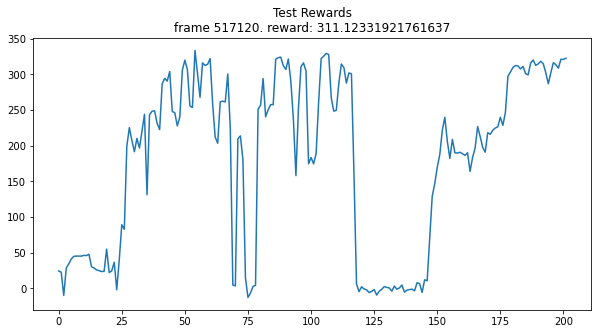

Frame 517120. reward: 322


In [15]:
for _ in range(1000):
    log_probs = []
    values    = []
    states    = []
    actions   = []
    rewards   = []
    masks     = []

    for _ in range(PPO_STEPS):
        state = torch.FloatTensor(state).to(device)
        dist, value = model(state)

        action = dist.sample()
        # each state, reward, done is a list of results from each parallel environment
        next_state, reward, done, _ = envs.step(action.cpu().numpy())
        log_prob = dist.log_prob(action)

        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
        masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))

        states.append(state)
        actions.append(action)

        state = next_state
        frame_idx += 1
        

    next_state = torch.FloatTensor(next_state).to(device)
    _, next_value = model(next_state)
    returns = compute_gae(next_value, rewards, masks, values)

    returns   = torch.cat(returns).detach()
    log_probs = torch.cat(log_probs).detach()
    values    = torch.cat(values).detach()
    states    = torch.cat(states)
    actions   = torch.cat(actions)
    advantage = returns - values
    advantage = normalize(advantage)

    ppo_update(frame_idx, states, actions, log_probs, returns, advantage)
    train_epoch += 1

    if train_epoch % TEST_EPOCHS == 0:
        test_reward = np.mean([test_env(env, model, device) for _ in range(NUM_TESTS)])
        writer.add_scalar("test_rewards", test_reward, frame_idx)
        test_rewards.append(test_reward)
        plot(frame_idx, test_rewards)
        print('Frame %s. reward: %.3s' % (frame_idx, test_reward))
        # Save a checkpoint every time we achieve a best reward
        if best_reward is None or best_reward < test_reward:
            if best_reward is not None:
                print("Best reward updated: %.3f -> %.3f" % (best_reward, test_reward))
                name = "%s_best_%+.3f_%d.dat" % (experiment_name, test_reward, frame_idx)
                fname = os.path.join('.', 'checkpoints', name)
                torch.save(model.state_dict(), fname)
            best_reward = test_reward
        if test_reward > TARGET_REWARD: early_stop = True

## Testing 
I included three learnt policies (as model checkpoints). The last training process displayed above corresponds to the last model. Because the performance of the models can decrease during training, the checkpoints correspond to the best performance during the whole training process. 

In [22]:
ENV_ID = "Swimmer-v3"
HIDDEN_SIZE = 256

model_name = "best_checkpoints/training1_Swimmer-v3_best_+298.652_332800.dat"
model_name = "best_checkpoints/training2_Swimmer-v3_best_+265.759_227840.dat"
model_name = "best_checkpoints/training3_Swimmer-v3_best_+333.809_140800.dat"

env = gym.make(ENV_ID)
num_inputs  = env.observation_space.shape[0]
num_outputs = env.action_space.shape[0]

use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

model = ActorCritic(num_inputs, num_outputs, HIDDEN_SIZE).to(device)
model.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [23]:
def test_env(env, model, device, deterministic=True):
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        action = dist.mean.detach().cpu().numpy()[0] if deterministic \
            else dist.sample().cpu().numpy()[0]
        next_state, reward, done, _ = env.step(action)
        state = next_state
        total_reward += reward
        print(f"{total_reward=:6.3f}", end="\r")
        env.render()
    print()
    return total_reward

for i in range(3):
    test_env(env, model, device, True)

Creating window glfw
total_reward=345.737
total_reward=332.818
total_reward=332.808


## Results
More detailed tensorboard training statistics from some of the runs are are in the `selected_runs` folder. Images of interesting graphs are provided below.

The algorithm is consistently able to achieve total reward around 300, which is more than twice as much as in the [openai Spinning Up bencmark](https://spinningup.openai.com/en/latest/spinningup/bench.html#swimmer-pytorch-versions).

The last training (graph shown) took 45 minutes on a AMD Ryzen 7 4700U laptop (8 cores, 2 - 4.1 GHz). In total the algorithm learnt from approx. 4 milion environment steps (4000 episodes).

First time it crossed the 90 reward threashold (better then just "jump") was after 532 episodes.

### Learnt behavior

In [21]:
Video("swimmer.mp4")

* First it learns the jump (only a single motion that pushes the worm at the start of the episode)
* At some point, the PPO discovers the slithering motion, which is much more effective. I was not able to discover this type of policy with DDQN.
* In some configurations the algorithm learnt to use jellyfish-like motion, which was a bit better than the jump. It consisted of two phases - a fast contraction and a slow opening. Because of the slow opening, it was a lot slower then the slithering.


### Interesting observations
* The agent can learn the initial "jump" motion realy fast
* It takes much longer time to start learning a behavior that leads to a continuous motion.
* The time when the agent discoveres the continuous behavior varies a lot in different trainigs
* During the training sometimes the agent seems to forget everything (like in the step ~120 in the Test rewards graph)
    * but then it gets quickly back to a good reward, so it still remembers something
* The policies of the three models are quite different, even though they are learnet with the same algorithm and hyperparameters.
    * the first model learnt to start with a sort of a jump and then continues to slither
    * the third model does not do any jump and just starts with the slither
  

## Training metrics

Here are some graphs from the training process of the previous trainings. The last training (corresponding to the test-rewards graph above) is the red one, the second model is the blue one and the first model is the orange one.

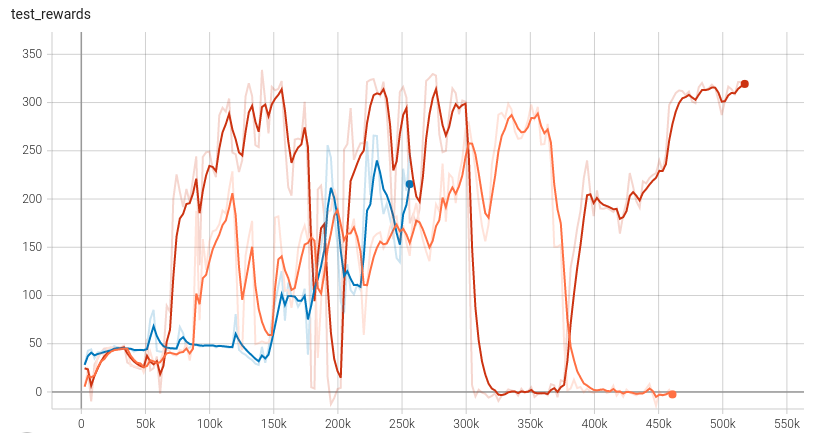

We can se that during orange and red training, the model performance collapsed at one point and in the case of the orange one, it was not able to recover.

---
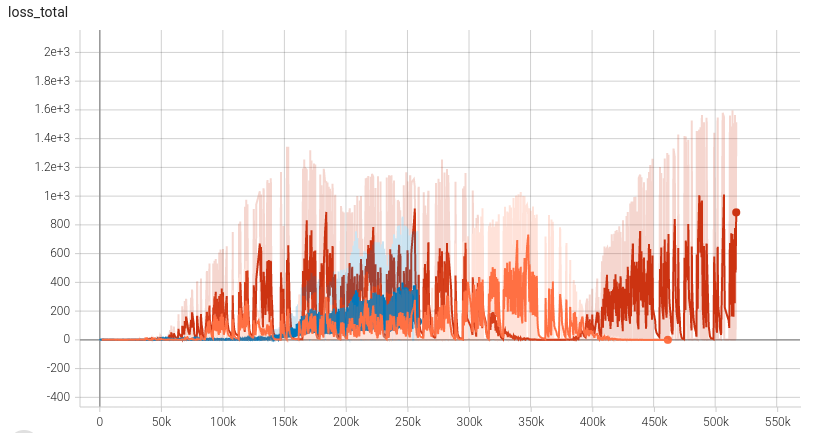

We can see that during the performance collapse, the models loss was very small and thus the models were not learning anything new.

---
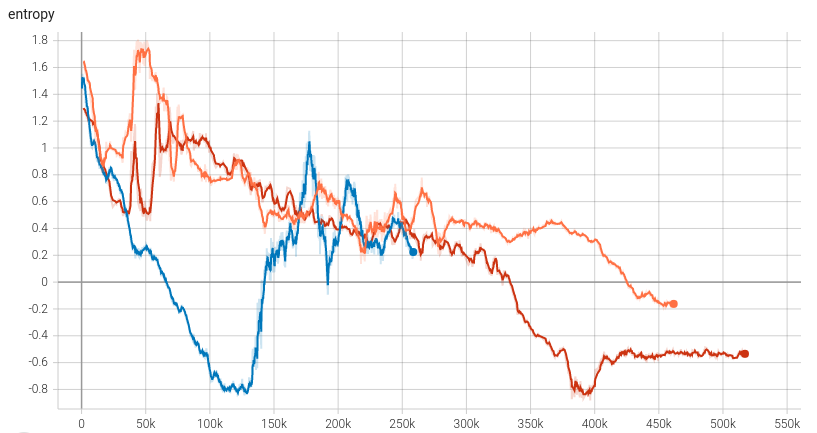

High entropy means the output distibution of actions has big variance. We can see, that at the begining the entropy is getting lower, because the agent learnt the "jump" and it is getting more sure in executing it. But once it learns the slither, the enropy shoots up, because the new behavior is not completely explored yet.